In [24]:
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
plt.style.use('dark_background')

In [26]:
def cargar_csvs(carpeta):
    archivos = glob.glob(os.path.join(carpeta, '*.csv'))#Carga de los datos
    dataframes = [pd.read_csv(f) for f in archivos]
    return pd.concat(dataframes, ignore_index=True)

In [27]:
def convertir_a_vector(texto):
    # Elimina corchetes y convierte a float
    texto = texto.replace('[', '').replace(']', '').replace('\n', ' ')
    # Corta y filtra los strings
    cleaned_values = [x for x in texto.strip().split() if x and x != '...']
    # Valores validos a float
    if cleaned_values:
        return np.array([float(x) for x in cleaned_values])
    else:
        # Array vacio si no hay datos validos
        return np.array([])

In [28]:
carpeta = './datos'  #Carga de los datos
df = cargar_csvs(carpeta)
df['features'] = df['data'].apply(convertir_a_vector)
df = df[df['features'].apply(lambda x: x.size > 0)]# Remover filas con vectores vacíos si existen
Longitudes = df['features'].apply(len)
print(df.columns)

Index(['object_id', 'data', 'label', 'features'], dtype='object')


In [29]:
# Se asegura de que todos los vectores tengan la misma longitud, para poder pasarlso a la matriz
if not Longitudes.nunique() <= 1:
    raise ValueError("Vectores no uniformes.")

if Longitudes.empty or Longitudes.iloc[0] == 0:
    raise ValueError("No hay valores validos.")

Largo_vector = Longitudes.iloc[0]
X = np.stack(df['features'].values)
y_raw = df['label'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(Largo_vector,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')
    ])
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
history = model.fit(X_train, y_train, epochs=1000,validation_split=0.2)

Epoch 1/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6995 - loss: 0.9080 - val_accuracy: 0.8269 - val_loss: 0.5753
Epoch 2/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8175 - loss: 0.6830 - val_accuracy: 0.8269 - val_loss: 0.5656
Epoch 3/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8155 - loss: 0.6613 - val_accuracy: 0.8269 - val_loss: 0.5619
Epoch 4/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8221 - loss: 0.6218 - val_accuracy: 0.8269 - val_loss: 0.5576
Epoch 5/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8204 - loss: 0.5937 - val_accuracy: 0.8269 - val_loss: 0.5610
Epoch 6/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8121 - loss: 0.6289 - val_accuracy: 0.8269 - val_loss: 0.5562
Epoch 7/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8208 - loss: 0.6017 - val_accuracy: 0.8269 - val_loss: 0.5542
Epoch 8/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8274 - loss: 0.5758 -

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8173 - loss: 4.6704

Precisión: 0.80


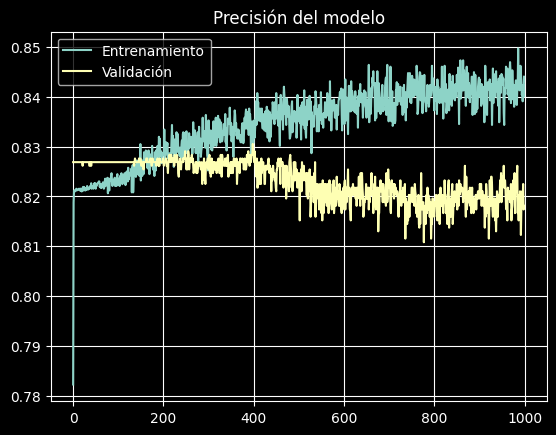

In [32]:
# Evaluación
loss, acc = model.evaluate(X_test, y_test)
print(f"\nPrecisión: {acc:.2f}")
plt.plot(history.history['accuracy'], label='Entrenamiento')#Vemos que tal los resultados del entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # Obtener las clases predichas

# Calcular el f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"f1 score: {f1:.2f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
f1 score: 0.74


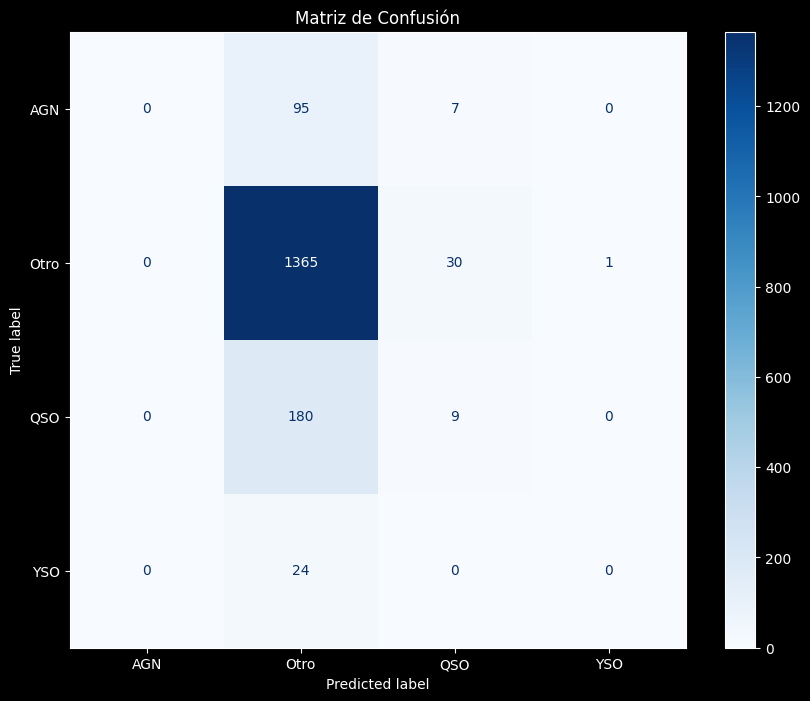

In [34]:
cm = confusion_matrix(y_test, y_pred)

class_names = encoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot de la matriz
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión')
plt.show()

In [35]:
# Guardar modelo
model.save('modelo_alertas.keras')